<a href="https://colab.research.google.com/github/RobertoAlessandri/CNN_DOA/blob/main/dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install pyroomacoustics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%ls /content/drive/MyDrive/Github/CNN_DOA/TIMIT/TEST/DR1/FAKS0/

SA1.PHN  SA2.WAV     SI2203.PHN  SI943.WAV  SX223.PHN  SX313.WAV  SX43.PHN
SA1.TXT  SA2.WRD     SI2203.TXT  SI943.WRD  SX223.TXT  SX313.WRD  SX43.TXT
SA1.WAV  SI1573.PHN  SI2203.WAV  SX133.PHN  SX223.WAV  SX403.PHN  SX43.WAV
SA1.WRD  SI1573.TXT  SI2203.WRD  SX133.TXT  SX223.WRD  SX403.TXT  SX43.WRD
SA2.PHN  SI1573.WAV  SI943.PHN   SX133.WAV  SX313.PHN  SX403.WAV
SA2.TXT  SI1573.WRD  SI943.TXT   SX133.WRD  SX313.TXT  SX403.WRD


In [5]:
import os
import pandas as pd

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

dirName = '/content/drive/MyDrive/Github/CNN_DOA/TIMIT/TEST/';
# Get the list of all files in directory tree at given path
listOfFiles = getListOfFiles(dirName)
listOfWavs = list()
for fileName in listOfFiles:
  if fileName.endswith('.WAV'):
    listOfWavs.append(fileName)

In [6]:
import librosa
import numpy as np
wav_test = []
max_length = 0
for wavPath in listOfWavs[:10]:
  x, sr = librosa.load(wavPath, sr=None)
  if (len(x) > max_length):
    max_length = len(x)
  x = x.reshape(len(x), 1)  
  wav_test.append(x)

audiofiles = np.zeros((max_length, len(wav_test)))
for i in range(0, len(wav_test)):
  wav = np.append(wav_test[i], np.zeros((max_length - wav_test[i].shape[0], 1)), axis=0)
  audiofiles[:,i] = wav.reshape(wav.shape[0])



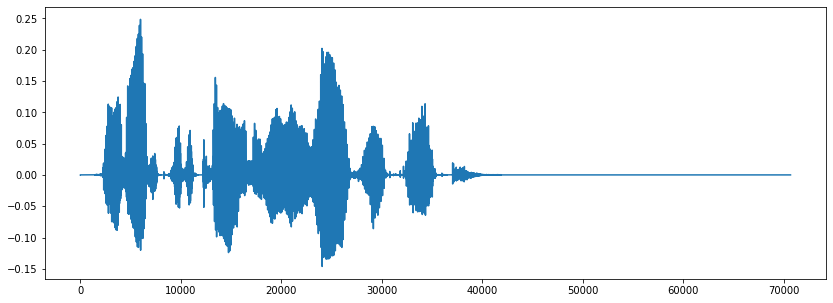

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(audiofiles[:,5])

In [12]:
import IPython.display as ipd 

ipd.Audio(audiofiles[:,0], rate=sr)

The desired RT60 was 0.5
The measured RT60 is 0.7813125000000001


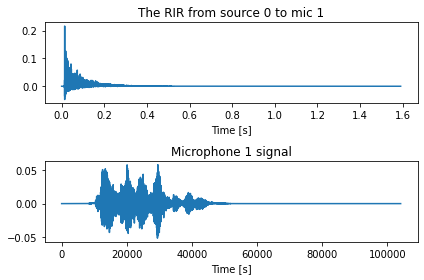

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from scipy.io import wavfile

# The desired reverberation time and dimensions of the room
rt60_tgt = 0.5  # seconds
room_dim = [10, 7.5, 3.5]  # meters

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
fs = sr
audio = audiofiles[:,0]

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)

# place the source in the room
room.add_source([2.5, 3.73, 1.76], signal=audio, delay=0.5)

# define the locations of the microphones
mic_locs = np.c_[
    [6.3, 4.87, 1.2], [6.3, 4.93, 1.2],  # mic 1  # mic 2
]

# finally place the array in the room
room.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.simulate()

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")

# plot signal at microphone 1
plt.subplot(2, 1, 2)
plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

In [14]:
ipd.Audio(room.mic_array.signals[1, :], rate=sr)

In [ ]:
import pyroomacoustics as pra

# The desired reverberation time and dimensions of the room
rt60 = 0.3  # seconds
room_dim = [9.64, 7.04, 2.95]  # meters
max_order = 3200

# Create the room
room = pra.ShoeBox(
    room_dim, fs=sr, max_order=max_order, absorption = None
)

# place the source in the room
room.add_source([room_dim[0]/2 + 1.5, room_dim[1]/2, 1.5], signal=audiofiles[:,0])
mics = pra.circular_microphone_array_xyplane([room_dim[0]/2 + 1.5, room_dim[1]/2, 1.5], M=4, radius=0.02, fs=sr, phi0=0)

room.add_microphone_array(mics)


# Run the simulation (this will also build the RIR automatically)
room.simulate()

plt.figure()
plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")
